### Questão (a)
Aplique uma rede MLP com uma camada intermediária e analise (1) a acurácia e (2) a matriz de confusão para
os dados de teste obtidas pela melhor versão desta rede. Descreva a metodologia e a arquitetura empregada,
bem como todas as escolhas feitas.

In [113]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical

from medmnist import BloodMNIST

In [114]:
# Importing data

INPUT_N = 28

train_dataset = BloodMNIST(split="train", download=True, size=INPUT_N)

X_train_full = np.zeros([len(train_dataset), INPUT_N, INPUT_N, 3]) 

y_train_full = np.zeros([len(train_dataset), 1])

for i in range(len(train_dataset)):
    x, y_train_full[i] = train_dataset[i]
    X_train_full[i] = np.array(x)/255.0
    
i_val = int(len(train_dataset)*0.7)

X_train = X_train_full[:i_val]
y_train = y_train_full[:i_val]

X_val = X_train_full[i_val:]
y_val = y_train_full[i_val:]

print('Number of samples in train dataset: '+str(len(train_dataset)))

print('Shape of data in train dataset: '+str(X_train.shape)+" "+str(y_train.shape))

print('Shape of data in validation dataset: '+str(X_val.shape)+" "+str(y_val.shape))

test_dataset = BloodMNIST(split="test", download=True, size=INPUT_N)

X_test = np.zeros([len(test_dataset), INPUT_N, INPUT_N, 3])

y_test = np.zeros([len(test_dataset), 1])

for i in range(len(test_dataset)):
    x, y_test[i] = test_dataset[i]
    X_test[i] = np.array(x)/255.0

print('Number of samples in test dataset: '+str(len(test_dataset)))

print('Shape of data in test dataset: '+str(X_test.shape)+" "+str(y_test.shape))

classes_labels = ['Basófilos', 'Eosinófilos', 'Eritroblastos', 'Granulócitos imaturos',
                  'Linfócitos', 'Monócitos', 'Neutrófilos', 'Plaquetas']


Using downloaded and verified file: /home/toffanetto/.medmnist/bloodmnist.npz
Number of samples in train dataset: 11959
Shape of data in train dataset: (8371, 28, 28, 3) (8371, 1)
Shape of data in validation dataset: (3588, 28, 28, 3) (3588, 1)
Using downloaded and verified file: /home/toffanetto/.medmnist/bloodmnist.npz
Number of samples in test dataset: 3421
Shape of data in test dataset: (3421, 28, 28, 3) (3421, 1)


1.0


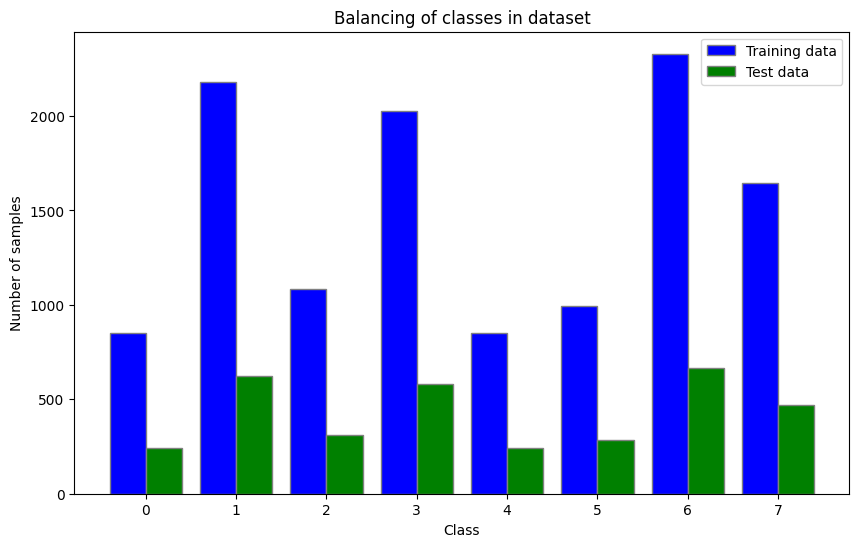

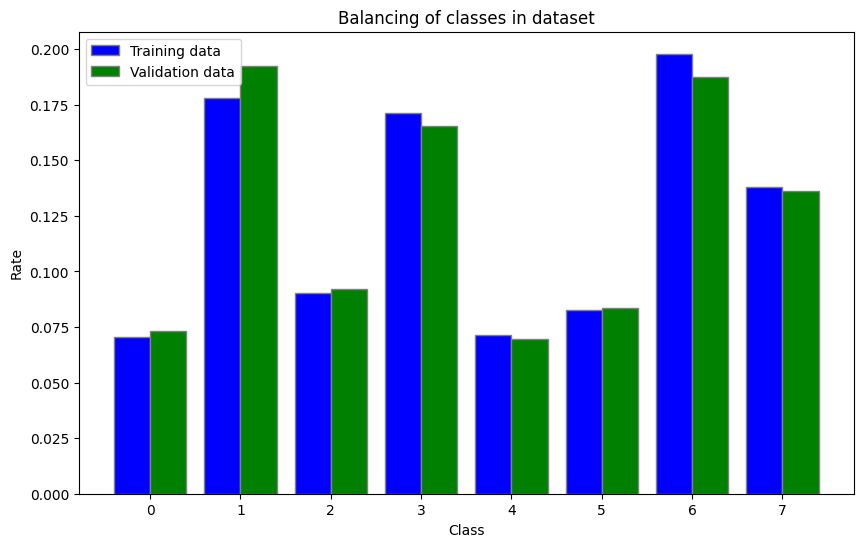

In [184]:
# Dataset balancing

train_one_hot = to_categorical(y_train_full)
test_one_hot =  to_categorical(y_test)
                                 
train_balancing = np.sum(train_one_hot, axis=0)
test_balancing = np.sum(test_one_hot, axis=0)
test_balancing_norm = test_balancing/np.sum(test_balancing, axis=0)

barWidth = 0.4

plt.figure(figsize=(10,6))
 
# Set position of bar on X axis 
br1 = np.arange(len(train_balancing)) 
br2 = [x + barWidth for x in br1] 
 
# Make the plot
plt.bar(br1, train_balancing, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Training data') 
plt.bar(br2, test_balancing, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Test data') 
 
# Adding Xticks 
plt.xlabel('Class') 
plt.ylabel('Number of samples') 
plt.xticks([r + barWidth/2 for r in range(len(train_balancing))], 
        ['0', '1', '2', '3', '4', '5', '6', '7'])
plt.title('Balancing of classes in dataset')
 
plt.legend(loc='upper right')

plt.savefig("../plot/Balancing_of_classes.pdf", format="pdf", bbox_inches="tight")

# Using holdout

train_one_hot = to_categorical(y_train)
val_one_hot =  to_categorical(y_val)
                                 
train_balancing = np.sum(train_one_hot, axis=0)
val_balancing = np.sum(val_one_hot, axis=0)

train_balancing = train_balancing/np.sum(train_balancing)
val_balancing = val_balancing/np.sum(val_balancing)

barWidth = 0.4

plt.figure(figsize=(10,6))
 
# Set position of bar on X axis 
br1 = np.arange(len(train_balancing)) 
br2 = [x + barWidth for x in br1] 
 
# Make the plot
plt.bar(br1, train_balancing, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Training data') 
plt.bar(br2, val_balancing, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Validation data') 
 
# Adding Xticks 
plt.xlabel('Class') 
plt.ylabel('Rate') 
plt.xticks([r + barWidth/2 for r in range(len(train_balancing))], 
        ['0', '1', '2', '3', '4', '5', '6', '7'])
plt.title('Balancing of classes in dataset')
 
plt.legend(loc='upper left')

plt.savefig("../plot/Balancing_of_classes_holdout.pdf", format="pdf", bbox_inches="tight")

---
### Busca pela melhor rede

Busca em grid variando alguns valores como:

- Quantidade de neuronios (512, 1024, 2048, 4096, 8192)
- Função de ativação (sigmoid, ReLU)
- Dropout (0, 0,25, 0,5)
- Otimizador (adam, sgd)

Treinar muitas épocas com a callback de salvar a melhor época

---

In [167]:
def build_and_test_mlp(n_neurons=64, activation_fnc="relu", dropout=0.0, optimizer="sgd", epochs=300):
    
    tf.keras.backend.clear_session() # Free memory and clear old models in session
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=[INPUT_N,INPUT_N,3]))
    model.add(tf.keras.layers.Dense(n_neurons,activation=activation_fnc))
    model.add(tf.keras.layers.Dropout(rate=dropout))
    model.add(tf.keras.layers.Dense(8, activation="softmax"))
    
    model.summary()
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint("../model/mlp/mlp_"+str(n_neurons)+"_"+(activation_fnc)+"_"+str(dropout)+"_"+(optimizer)+".weights.h5",
                                                    save_best_only=True, save_weights_only=True)
    
    history = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpoint_cb])
    
    loss, accuracy = model.evaluate(X_test,y_test)
    
    model_specs = dict(n_neurons=n_neurons,
                       activation_fnc=activation_fnc,
                       dropout=dropout,
                       optimizer=optimizer,
                       loss=loss,
                       accuracy=accuracy)
    
    return model_specs, history, model

/home/toffanetto/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       150,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,112 (590.28 KB)

 Trainable params: 151,112 (590.28 KB)

 Non-trainable params: 0 (0.00 B)

262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3092 - loss: 1.8353 - val_accuracy: 0.5582 - val_loss: 1.3624
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5588 - loss: 1.3712
{'n_neurons': 64, 'activation_fnc': 'relu', 'dropout': 0.0, 'optimizer': 'sgd', 'loss': 1.3629659414291382, 'accuracy': 0.5539315938949585}


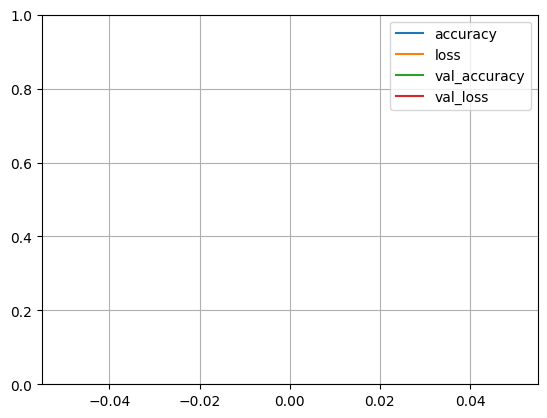

In [171]:
# Test custom model

model_specs, history, _ = build_and_test_mlp(epochs=100)

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.ylim([0,1])

print(model_specs)


In [117]:
epochs = 500

n_neurons_search = [256, 512, 1024, 2048, 4096]

activation_fnc_search = ["relu", "sigmoid"]

dropout_search = [0.0, 0.25, 0.5]

optimizer_search = ["adam", "sgd"]


In [118]:
############################################
# Number of neurons search

n_neurons_models = []
n_neurons_historys = []

for n_neurons in n_neurons_search:
    print("|++| Training for "+str(n_neurons)+" neurons |++|\n")
    model_specs, history, _ = build_and_test_mlp(n_neurons=n_neurons,epochs=epochs)
    n_neurons_models.append(model_specs)
    n_neurons_historys.append(history)
    
best_model_neurons = dict(n_neurons=0,
                          activation_fnc="",        
                          dropout=0,
                          optimizer="",
                          loss=0,
                          accuracy=0)

for model in n_neurons_models:
    if model["accuracy"] > best_model_neurons["accuracy"]:
        best_model_neurons = model
    
best_n_neurons = best_model_neurons["n_neurons"]

print(n_neurons_models)
print(best_n_neurons)


|++| Training for 256 neurons |++|



/home/toffanetto/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       602,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,424 (2.31 MB)

 Trainable params: 604,424 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3357 - loss: 1.8090 - val_accuracy: 0.4504 - val_loss: 1.4458
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5376 - loss: 1.2482 - val_accuracy: 0.6076 - val_loss: 1.0736
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6150 - loss: 1.0542 - val_accuracy: 0.6315 - val_loss: 1.0120
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6404 - loss: 1.0005 - val_accuracy: 0.5814 - val_loss: 0.9896
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6358 - loss: 0.9860 - val_accuracy: 0.6513 - val_loss: 0.9207
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6776 - loss: 0.8969 - val_accuracy: 0.6984 - val_loss: 0.8283
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6876 - loss: 0.8813 - val_accuracy: 0.6703 - val_loss: 0.8731
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7004 - loss: 0.8468 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,204,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,208,840 (4.61 MB)

 Trainable params: 1,208,840 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3359 - loss: 1.8203 - val_accuracy: 0.3386 - val_loss: 1.3621
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5376 - loss: 1.2219 - val_accuracy: 0.6118 - val_loss: 1.0691
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6113 - loss: 1.0607 - val_accuracy: 0.6067 - val_loss: 1.0733
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6502 - loss: 0.9667 - val_accuracy: 0.6140 - val_loss: 0.9594
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6594 - loss: 0.9451 - val_accuracy: 0.6382 - val_loss: 0.9484
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6765 - loss: 0.9081 - val_accuracy: 0.6555 - val_loss: 0.9271
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6877 - loss: 0.8669 - val_accuracy: 0.5652 - val_loss: 1.0245
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6911 - loss: 0.8417 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,672 (9.22 MB)

 Trainable params: 2,417,672 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3350 - loss: 1.8623 - val_accuracy: 0.4827 - val_loss: 1.4074
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5560 - loss: 1.1785 - val_accuracy: 0.6023 - val_loss: 1.0973
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6081 - loss: 1.0596 - val_accuracy: 0.5725 - val_loss: 1.0474
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6432 - loss: 0.9839 - val_accuracy: 0.7076 - val_loss: 0.8571
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6670 - loss: 0.9178 - val_accuracy: 0.7216 - val_loss: 0.8466
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6671 - loss: 0.9110 - val_accuracy: 0.6469 - val_loss: 0.9241
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7013 - loss: 0.8489 - val_accuracy: 0.6848 - val_loss: 0.8727
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6988 - loss: 0.8506 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     4,818,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,835,336 (18.45 MB)

 Trainable params: 4,835,336 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3374 - loss: 1.9350 - val_accuracy: 0.4002 - val_loss: 1.4718
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5629 - loss: 1.1613 - val_accuracy: 0.6452 - val_loss: 1.0161
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6126 - loss: 1.0506 - val_accuracy: 0.5616 - val_loss: 1.1395
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6373 - loss: 0.9788 - val_accuracy: 0.7004 - val_loss: 0.8666
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6617 - loss: 0.9405 - val_accuracy: 0.6104 - val_loss: 0.9354
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6841 - loss: 0.8781 - val_accuracy: 0.7322 - val_loss: 0.7952
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7084 - loss: 0.8519 - val_accuracy: 0.6486 - val_loss: 0.9236
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7202 - loss: 0.8008 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     9,637,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,670,664 (36.89 MB)

 Trainable params: 9,670,664 (36.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3424 - loss: 2.0208 - val_accuracy: 0.4242 - val_loss: 1.3908
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5767 - loss: 1.1592 - val_accuracy: 0.5953 - val_loss: 1.0041
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6346 - loss: 1.0099 - val_accuracy: 0.6349 - val_loss: 0.9887
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6722 - loss: 0.9302 - val_accuracy: 0.6945 - val_loss: 0.8797
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6875 - loss: 0.8915 - val_accuracy: 0.6413 - val_loss: 0.9327
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6824 - loss: 0.8916 - val_accuracy: 0.6647 - val_loss: 0.8949
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7025 - loss: 0.8348 - val_accuracy: 0.7506 - val_loss: 0.7427
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7091 - loss: 0.8270 - val_accu

In [127]:
############################################
# Activation function search

activation_fnc_models = []
activation_fnc_historys = []

for activation_fnc in activation_fnc_search:
    print("|++| Training for "+activation_fnc+" activation function |++|\n")
    model_specs, history, _ = build_and_test_mlp(n_neurons=best_n_neurons,activation_fnc=activation_fnc,
                                              epochs=epochs)
    activation_fnc_models.append(model_specs)
    activation_fnc_historys.append(history)
    
best_model_activation_fnc = dict(n_neurons=0,
                                 activation_fnc="",    
                                 dropout=0,             
                                 optimizer="",          
                                 loss=0,                 
                                 accuracy=0)

for model in activation_fnc_models:
    if model["accuracy"] > best_model_activation_fnc["accuracy"]:
        best_model_activation_fnc = model

best_activation_fnc = best_model_activation_fnc["activation_fnc"]

print(activation_fnc_models)
print(best_activation_fnc)
    


|++| Training for relu activation function |++|



/home/toffanetto/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,672 (9.22 MB)

 Trainable params: 2,417,672 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3340 - loss: 1.8664 - val_accuracy: 0.6310 - val_loss: 1.1675
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5667 - loss: 1.1928 - val_accuracy: 0.6324 - val_loss: 1.0620
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6044 - loss: 1.0596 - val_accuracy: 0.5510 - val_loss: 1.0956
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6461 - loss: 0.9743 - val_accuracy: 0.6413 - val_loss: 0.9390
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6621 - loss: 0.9385 - val_accuracy: 0.7185 - val_loss: 0.8390
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6914 - loss: 0.8696 - val_accuracy: 0.6628 - val_loss: 0.9044
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6833 - loss: 0.8753 - val_accuracy: 0.7280 - val_loss: 0.7846
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7079 - loss: 0.8186 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,672 (9.22 MB)

 Trainable params: 2,417,672 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2596 - loss: 1.9425 - val_accuracy: 0.3531 - val_loss: 1.7437
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4196 - loss: 1.6108 - val_accuracy: 0.4875 - val_loss: 1.4804
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4604 - loss: 1.4539 - val_accuracy: 0.5443 - val_loss: 1.3675
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5320 - loss: 1.3231 - val_accuracy: 0.5198 - val_loss: 1.3019
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5740 - loss: 1.2451 - val_accuracy: 0.6215 - val_loss: 1.1970
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6029 - loss: 1.1847 - val_accuracy: 0.5978 - val_loss: 1.1410
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6335 - loss: 1.1126 - val_accuracy: 0.6226 - val_loss: 1.0890
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6321 - loss: 1.0707 - val_accu

In [128]:
############################################
# Dropout search

dropout_models = []
dropout_historys = []

for dropout in dropout_search:
    print("|++| Training for "+str(dropout)+" dropout rate |++|\n")
    model_specs, history, _ = build_and_test_mlp(n_neurons=best_n_neurons,activation_fnc=best_activation_fnc, 
                                              dropout=dropout, epochs=epochs)
    dropout_models.append(model_specs)
    dropout_historys.append(history)
    
best_model_dropout = dict(n_neurons=0,           
                          activation_fnc="",                
                          dropout=0,                       
                          optimizer="",            
                          loss=0,    
                          accuracy=0)

for model in dropout_models:
    if model["accuracy"] > best_model_dropout["accuracy"]:
        best_model_dropout = model

best_dropout = best_model_dropout["dropout"]

print(dropout_models)
print(best_dropout)

|++| Training for 0.0 dropout rate |++|



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,672 (9.22 MB)

 Trainable params: 2,417,672 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3393 - loss: 1.8601 - val_accuracy: 0.4443 - val_loss: 1.3182
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5428 - loss: 1.2136 - val_accuracy: 0.5825 - val_loss: 1.0761
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6085 - loss: 1.0589 - val_accuracy: 0.6274 - val_loss: 0.9917
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6464 - loss: 0.9825 - val_accuracy: 0.5262 - val_loss: 1.1844
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6493 - loss: 0.9523 - val_accuracy: 0.6302 - val_loss: 0.9591
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6716 - loss: 0.9069 - val_accuracy: 0.6803 - val_loss: 0.9025
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6845 - loss: 0.8699 - val_accuracy: 0.6246 - val_loss: 0.9783
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7067 - loss: 0.8282 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,672 (9.22 MB)

 Trainable params: 2,417,672 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3403 - loss: 1.9142 - val_accuracy: 0.4373 - val_loss: 1.3035
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5394 - loss: 1.2229 - val_accuracy: 0.5995 - val_loss: 1.1172
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6089 - loss: 1.0701 - val_accuracy: 0.6550 - val_loss: 1.0236
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6337 - loss: 0.9981 - val_accuracy: 0.5566 - val_loss: 1.1071
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6434 - loss: 0.9832 - val_accuracy: 0.6625 - val_loss: 0.9032
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6632 - loss: 0.9343 - val_accuracy: 0.5825 - val_loss: 1.0234
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6915 - loss: 0.8596 - val_accuracy: 0.7062 - val_loss: 0.8277
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6842 - loss: 0.8918 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,672 (9.22 MB)

 Trainable params: 2,417,672 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3279 - loss: 1.8436 - val_accuracy: 0.5351 - val_loss: 1.2681
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5160 - loss: 1.2889 - val_accuracy: 0.6731 - val_loss: 1.0476
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5842 - loss: 1.1367 - val_accuracy: 0.6477 - val_loss: 1.0099
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6086 - loss: 1.0707 - val_accuracy: 0.6920 - val_loss: 0.9085
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6275 - loss: 0.9996 - val_accuracy: 0.5858 - val_loss: 1.0445
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6574 - loss: 0.9465 - val_accuracy: 0.6187 - val_loss: 1.0431
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6510 - loss: 0.9422 - val_accuracy: 0.6159 - val_loss: 0.9955
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6649 - loss: 0.9190 - val_accu

In [129]:

############################################
# Optimizer search

optimizer_models = []
optimizer_historys = []

for optimizer in optimizer_search:
    print("|++| Training for "+optimizer+" optimizer |++|\n")
    model_specs, history, _ = build_and_test_mlp(n_neurons=best_n_neurons,activation_fnc=best_activation_fnc, 
                                              dropout=best_dropout, optimizer=optimizer, epochs=epochs)
    optimizer_models.append(model_specs)
    optimizer_historys.append(history)
    
best_model_optimizer = dict(n_neurons=0,           
                            activation_fnc="",                
                            dropout=0,                       
                            optimizer="",            
                            loss=0,    
                            accuracy=0)

for model in optimizer_models:
    if model["accuracy"] > best_model_optimizer["accuracy"]:
        best_model_optimizer = model

best_optimizer = best_model_optimizer["optimizer"]

print(optimizer_models)
print(best_optimizer)

|++| Training for adam optimizer |++|



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,672 (9.22 MB)

 Trainable params: 2,417,672 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3766 - loss: 2.5860 - val_accuracy: 0.6394 - val_loss: 1.0087
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6351 - loss: 1.0077 - val_accuracy: 0.6502 - val_loss: 0.9229
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6853 - loss: 0.8832 - val_accuracy: 0.7196 - val_loss: 0.8000
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7041 - loss: 0.8392 - val_accuracy: 0.7205 - val_loss: 0.7781
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7121 - loss: 0.8147 - val_accuracy: 0.6940 - val_loss: 0.8314
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7473 - loss: 0.7297 - val_accuracy: 0.7263 - val_loss: 0.7651
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7397 - loss: 0.7133 - val_accuracy: 0.7336 - val_loss: 0.7401
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7505 - loss: 0.6884 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,672 (9.22 MB)

 Trainable params: 2,417,672 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3403 - loss: 1.8987 - val_accuracy: 0.5290 - val_loss: 1.3521
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5595 - loss: 1.1902 - val_accuracy: 0.5337 - val_loss: 1.1231
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6189 - loss: 1.0524 - val_accuracy: 0.6486 - val_loss: 1.0151
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6257 - loss: 1.0180 - val_accuracy: 0.6352 - val_loss: 1.0312
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6583 - loss: 0.9247 - val_accuracy: 0.5223 - val_loss: 1.2385
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6800 - loss: 0.8913 - val_accuracy: 0.6820 - val_loss: 0.8682
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6949 - loss: 0.8547 - val_accuracy: 0.7065 - val_loss: 0.8223
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6992 - loss: 0.8536 - val_accu

In [130]:
print(best_model_neurons["accuracy"])
print(best_model_activation_fnc["accuracy"])
print(best_model_dropout["accuracy"])
print(best_model_optimizer["accuracy"])

best_model = dict(n_neurons=best_n_neurons,
                  activation_fnc=best_activation_fnc,
                  dropout=best_dropout,
                  optimizer=best_optimizer)

print("\nBest model founded: "+str(best_model))
    


0.8745980858802795
0.8716749548912048
0.8737211227416992
0.8672902584075928

Best model founded: {'n_neurons': 1024, 'activation_fnc': 'relu', 'dropout': 0.0, 'optimizer': 'sgd'}


---
Uma vez definido o melhor modelo, obter dele:
- Acurácia (balanceada) 
- Matriz de confusão
- Comparar amostras que erraram 
  - O quanto errou, com qual classe confundiu
  - Comparação visual

---

In [172]:
model_specs, history, model = build_and_test_mlp(n_neurons=best_model["n_neurons"],activation_fnc=best_model["activation_fnc"],
                                          dropout=best_model["dropout"],optimizer=best_model["optimizer"], epochs=epochs)

print(model_specs)

/home/toffanetto/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,672 (9.22 MB)

 Trainable params: 2,417,672 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3311 - loss: 1.8798 - val_accuracy: 0.5831 - val_loss: 1.2740
Epoch 2/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5559 - loss: 1.1890 - val_accuracy: 0.6419 - val_loss: 1.0826
Epoch 3/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6149 - loss: 1.0681 - val_accuracy: 0.5978 - val_loss: 1.0240
Epoch 4/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6427 - loss: 0.9813 - val_accuracy: 0.6224 - val_loss: 0.9774
Epoch 5/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6522 - loss: 0.9473 - val_accuracy: 0.6137 - val_loss: 1.0263
Epoch 6/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6737 - loss: 0.9124 - val_accuracy: 0.6173 - val_loss: 1.0215
Epoch 7/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6949 - loss: 0.8553 - val_accuracy: 0.6812 - val_loss: 0.8471
Epoch 8/500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7074 - loss: 0.8501 - val_accu

---
### Loss and accuracy through training
---

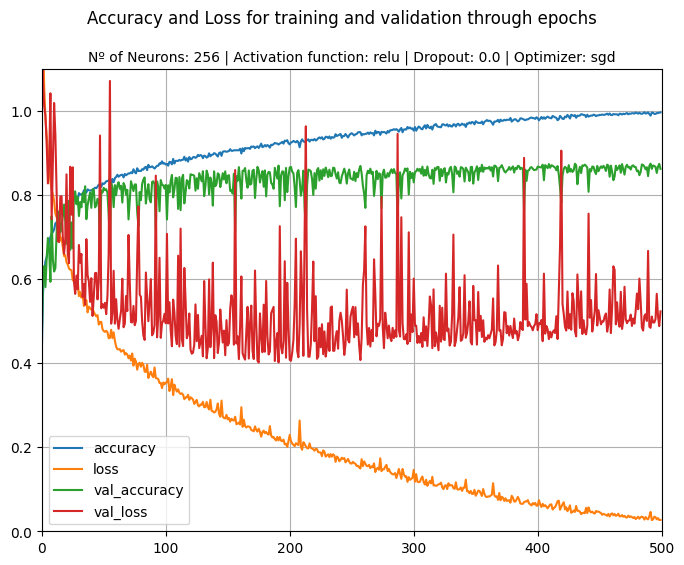

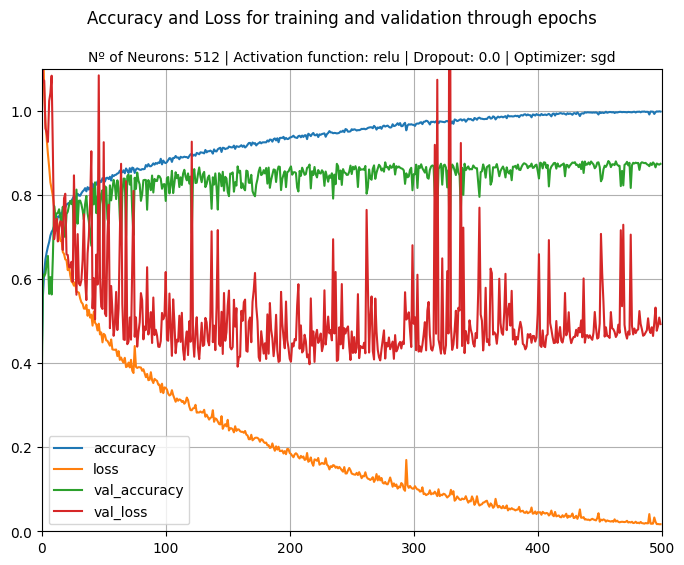

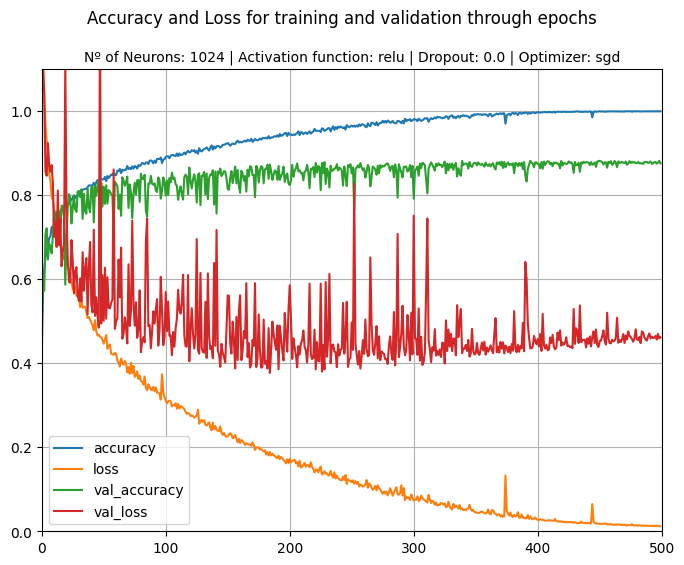

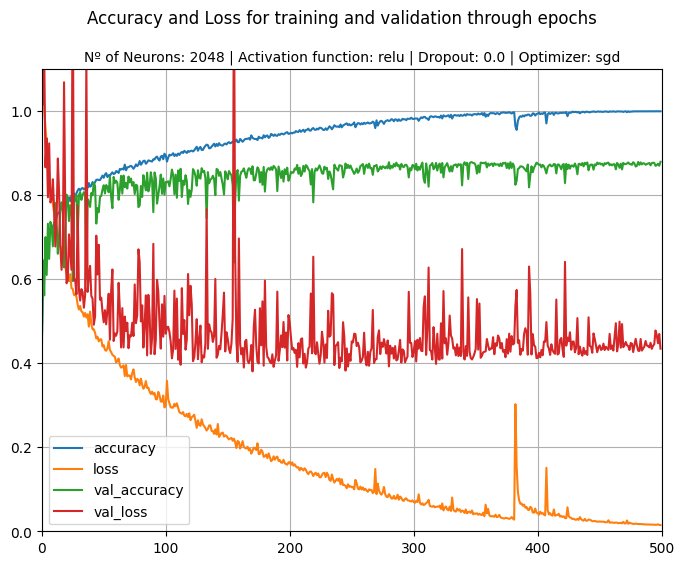

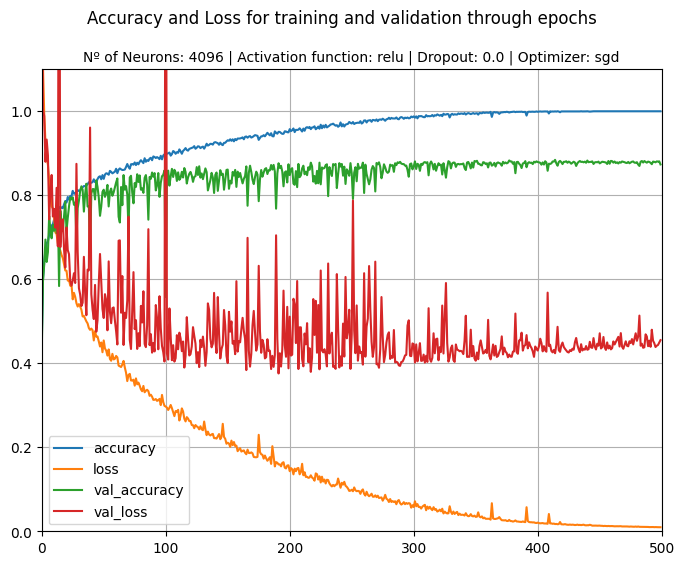

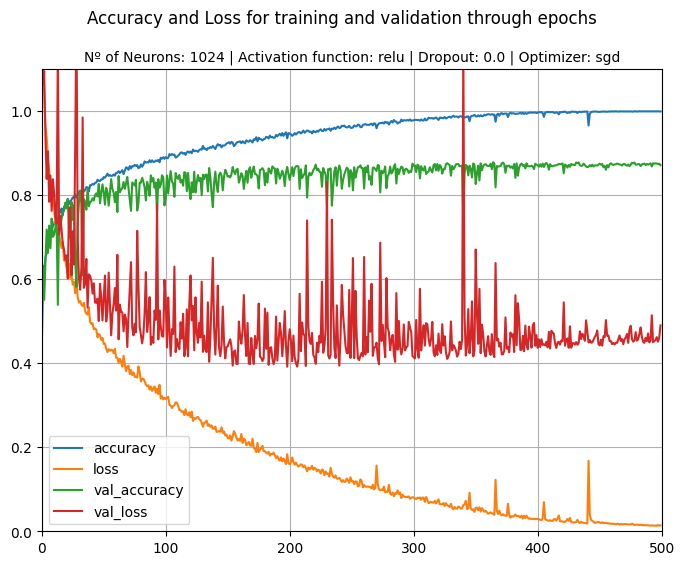

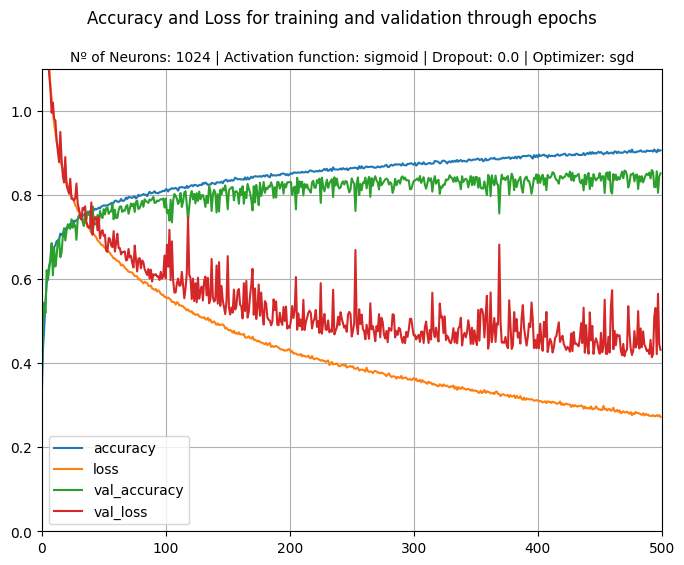

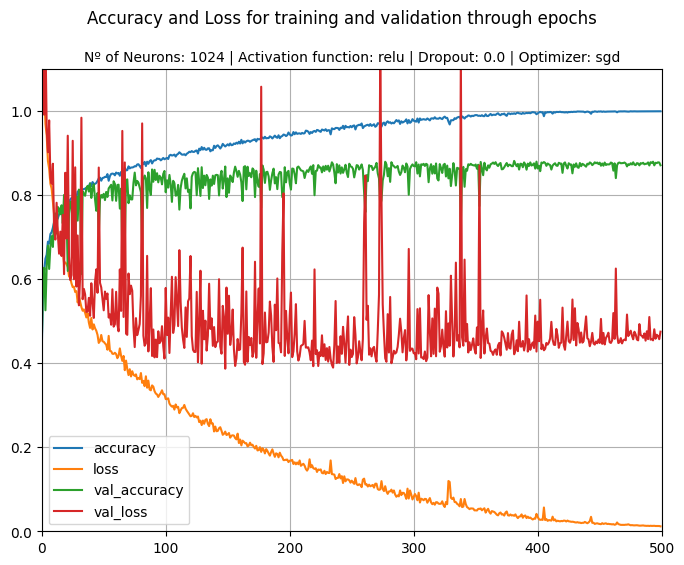

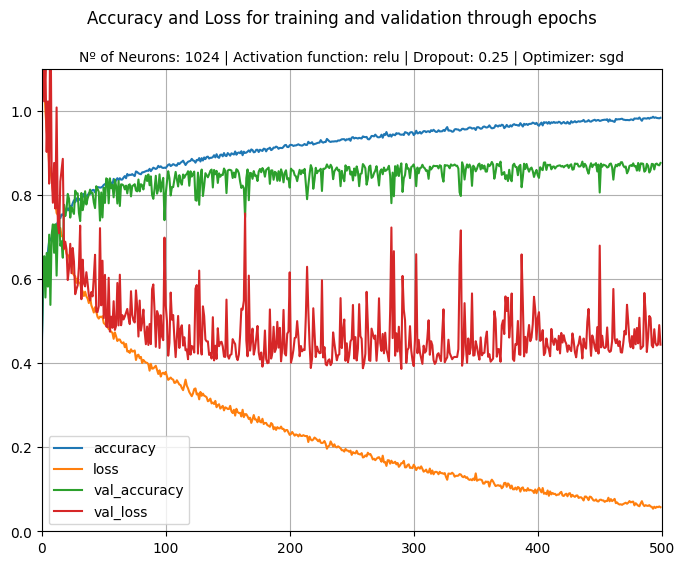

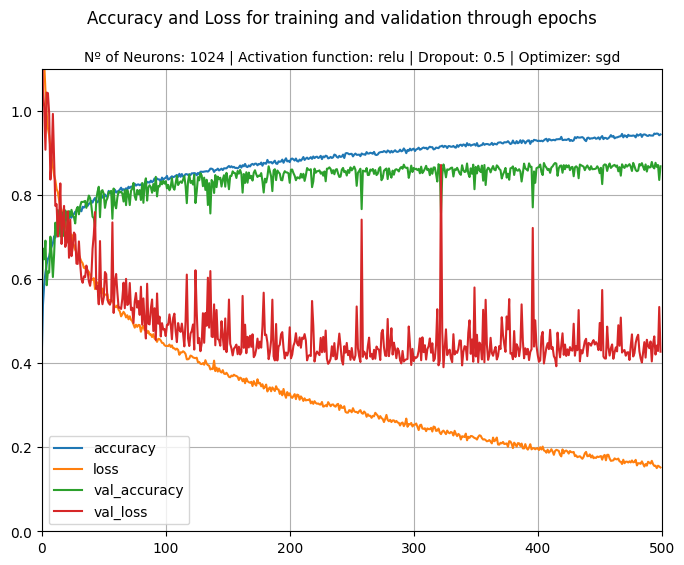

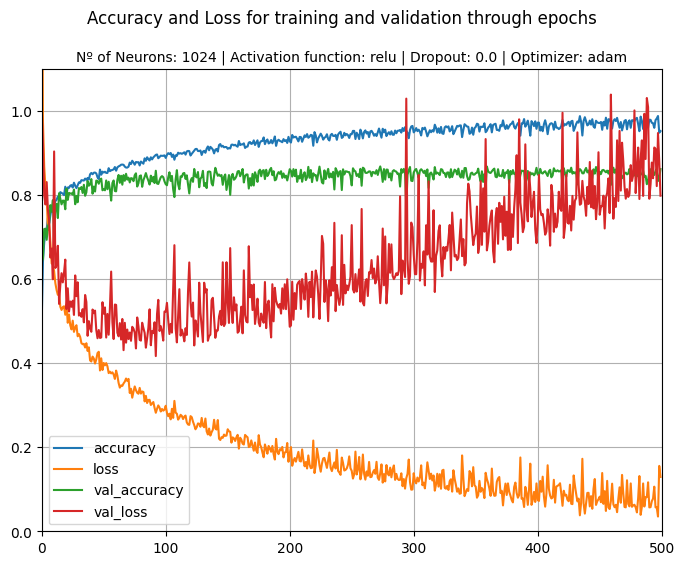

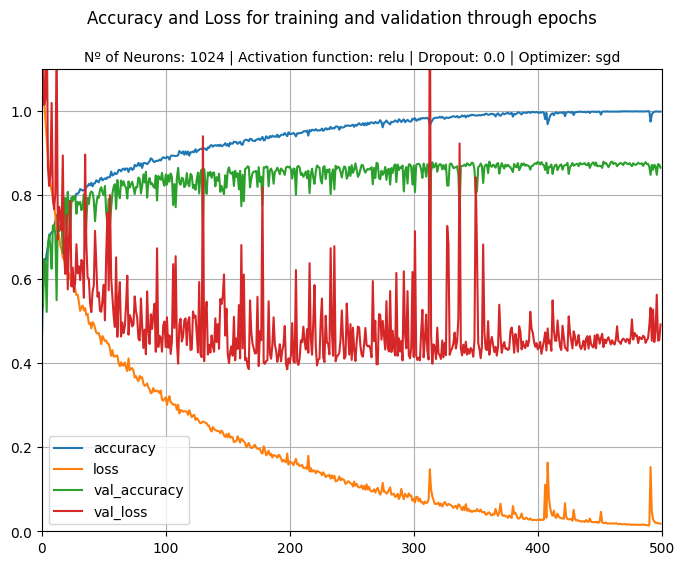

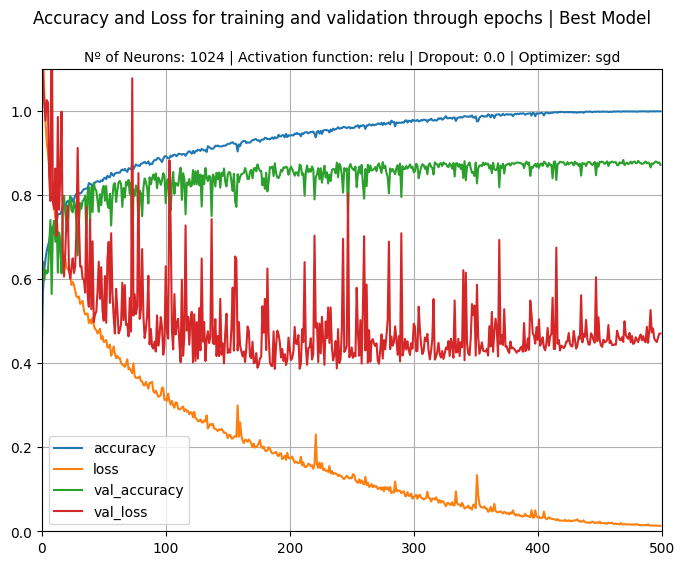

In [221]:
# Plot all loss & validation graphs
def plotLossAccuracy2Epochs(historyV, modelV, title_append=""):
    
    for model, history in zip(modelV, historyV):
        pd.DataFrame(history.history).plot(figsize=(8,6))
        plt.grid(True)
        plt.ylim([0,1.1])
        plt.xlim([0,epochs])
        plt.suptitle("Accuracy and Loss for training and validation through epochs"+title_append, fontsize=12)
        plt.title('Nº of Neurons: '+str(model["n_neurons"])+
                ' | Activation function: '+str(model["activation_fnc"])+
                ' | Dropout: '+str(model["dropout"])+
                ' | Optimizer: '+str(model["optimizer"]),fontsize=10)
        
        plt.savefig("../plot/mlp/mlp_"+str(model["n_neurons"])+"_"+
                    (model["activation_fnc"])+"_"+str(model["dropout"])+"_"+
                    (model["optimizer"])+title_append+".pdf",
                    format="pdf", bbox_inches="tight")
    
plotLossAccuracy2Epochs(n_neurons_historys, n_neurons_models)
plotLossAccuracy2Epochs(activation_fnc_historys, activation_fnc_models)
plotLossAccuracy2Epochs(dropout_historys, dropout_models)
plotLossAccuracy2Epochs(optimizer_historys, optimizer_models)
plotLossAccuracy2Epochs([history], [model_specs],title_append=" | Best Model")

---

### Evaluating best model

---

In [222]:
def rateModel(y,y_hat,classes_rate):
    
    hit = np.zeros(8)
    confusion_matrix = np.zeros([8,8])
    
    for i in range(len(y)):
        confusion_matrix[y[i], y_hat[i]] += 1
        
        hit[y[i]] += 1 if y[i] == y_hat[i] else 0
            
    ba = np.average(hit/(classes_rate*len(y)))
        
    return confusion_matrix, ba

def confusionMatrixExtract(confusion_matrix):
    score = {0 : {'Precision': 0, 'Recall': 0}, 
             1 : {'Precision': 0, 'Recall': 0}, 
             2 : {'Precision': 0, 'Recall': 0},
             3 : {'Precision': 0, 'Recall': 0},
             4 : {'Precision': 0, 'Recall': 0},
             5 : {'Precision': 0, 'Recall': 0},
             6 : {'Precision': 0, 'Recall': 0},
             7 : {'Precision': 0, 'Recall': 0}}
    
    for i in range(8):
        TP = FP = FN = 0
        for j in range(8):
            TP = confusion_matrix[i][j] if i == j else TP
            FP += confusion_matrix[i][j] if i != j else 0
            FN += confusion_matrix[j][i] if i != j else 0
            
        score[i]['Precision']= TP/(TP+FP)
        score[i]['Recall']= TP/(TP+FN)
    
    return score

In [223]:
y_hat_test_ohe = model.predict_on_batch(X_test)

y_hat_test = np.argmax(y_hat_test_ohe, axis=1)

confusion_matrix, ba = rateModel(np.uint8(np.squeeze(y_test)), y_hat_test, test_balancing_norm)

score = confusionMatrixExtract(confusion_matrix)

print('confusion_matrix = \n'+str(confusion_matrix))

print('\nAccuracy = '+str(model_specs["accuracy"]))

print('\nBA = '+str(ba)+"\n")

print("Class | Precision | Recall")
for i in range(8):
    print(str(i)+'\t'+str("{:.4f}".format(score[i]['Precision']))+'\t'+str("{:.4f}".format(score[i]['Recall'])))

confusion_matrix = 
[[201.   1.   0.  30.   2.  10.   0.   0.]
 [  3. 604.   0.   7.   1.   0.   9.   0.]
 [  4.   2. 276.  12.   4.   2.   8.   3.]
 [ 55.  18.   9. 438.   8.  21.  30.   0.]
 [ 17.   0.  15.  18. 188.   0.   5.   0.]
 [ 18.   2.   2.  57.   4. 197.   4.   0.]
 [  2.  20.  11.  20.   2.   2. 608.   1.]
 [  0.   0.   3.   0.   0.   0.   0. 467.]]

Accuracy = 0.8707979917526245

BA = 0.8511887697780749

Class | Precision | Recall
0	0.8238	0.6700
1	0.9679	0.9335
2	0.8875	0.8734
3	0.7565	0.7526
4	0.7737	0.8995
5	0.6937	0.8491
6	0.9129	0.9157
7	0.9936	0.9915
